Sources: 

- https://docs.ultralytics.com/models/yolov9

- https://wandb.ai/byyoung3/ML_NEWS/reports/YOLOv9-object-detection-tutorial---Vmlldzo4Njc2Njc4

- https://github.com/itberrios/CV_tracking/blob/main/kitti_tracker/1_kitti_object_detection_lidar.ipynb

In [2]:
# %pip install ultralytics

In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import cv2
from PIL import Image

from ultralytics import YOLO

from nuscenes.nuscenes import NuScenes

## Setup and Constants

In [4]:
%matplotlib inline

In [5]:
IOU_THRESHOLD = 0.6

In [6]:
CONFIDENCE_THRESHOLD = 0.4

In [7]:
print(torch.cuda.is_available())

False


/home/012392471@SJSUAD/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Load Model

In [8]:
model = YOLO('weights/yolov9t.pt')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.74M/4.74M [00:00<00:00, 11.7MB/s]


## Load Test Image

In [9]:
PREFIX = '../data/nuscenes'

In [10]:
nusc = NuScenes(version='v1.0-mini', dataroot=PREFIX, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.377 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [11]:
INDEX = 5

In [12]:
test_scene = nusc.scene[INDEX]

In [13]:
test_scene

{'token': 'c5224b9b454b4ded9b5d2d2634bbda8a',
 'log_token': '8ff48ad1df8e4966a2151730c92b7f3c',
 'nbr_samples': 40,
 'first_sample_token': 'c1676a2feac74eee8aa38ca3901787d6',
 'last_sample_token': '63c24b51feb94f14bec29022dae4975d',
 'name': 'scene-0796',
 'description': 'Scooter, peds on sidewalk, bus, cars, truck, fake construction worker, bicycle, cross intersection, car overtaking us'}

In [14]:
first_sample_token = test_scene['first_sample_token']

In [15]:
my_sample = nusc.get('sample', first_sample_token)
my_sample

{'token': 'c1676a2feac74eee8aa38ca3901787d6',
 'timestamp': 1538448744447639,
 'prev': '',
 'next': 'd6b0de49811b4d1b86a0933719c0c44a',
 'scene_token': 'c5224b9b454b4ded9b5d2d2634bbda8a',
 'data': {'RADAR_FRONT': '26d0c02b681f48bba9d4bde8fc68a9c7',
  'RADAR_FRONT_LEFT': '496dc8b327814f7ba48a74972bde1433',
  'RADAR_FRONT_RIGHT': 'f4b5941dcfa3400ea0a24f5fbe90cef5',
  'RADAR_BACK_LEFT': '1268ee4a07cf44c099017710c624ba7b',
  'RADAR_BACK_RIGHT': '9877d1dbb6624f1393962060f39c5452',
  'LIDAR_TOP': '17dcee974ba349e884f676670d0c66e7',
  'CAM_FRONT': '98bea7c1f83340119051b7b7a0185033',
  'CAM_FRONT_RIGHT': '28cbeca98a834194a4dc71c616a429ce',
  'CAM_BACK_RIGHT': '4118dd0fa03f451c99a09ee72a0d6fbb',
  'CAM_BACK_LEFT': '9706ab2aaf304042bfb731ebf33b35d8',
  'CAM_BACK': 'be22879d93f04150bb9466211012205e',
  'CAM_FRONT_LEFT': '272da8148606496f92712408680498c4'},
 'anns': ['3f295dcfa09a491ca53efbb2f048b963',
  '44928e4ac6134cacbf7c63429d38d021',
  'a89b46240ab7452cb990cc034efffd8c',
  'f2b2109b8c754caa8

In [16]:
sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
cam_front_data

{'token': '98bea7c1f83340119051b7b7a0185033',
 'sample_token': 'c1676a2feac74eee8aa38ca3901787d6',
 'ego_pose_token': '98bea7c1f83340119051b7b7a0185033',
 'calibrated_sensor_token': '1e2441fdd3bd41f2badbeb0a1775d1e6',
 'timestamp': 1538448744412460,
 'fileformat': 'jpg',
 'is_key_frame': True,
 'height': 900,
 'width': 1600,
 'filename': 'samples/CAM_FRONT/n015-2018-10-02-10-50-40+0800__CAM_FRONT__1538448744412460.jpg',
 'prev': '',
 'next': '98f86e7371c241c0838522e4c9c06e4c',
 'sensor_modality': 'camera',
 'channel': 'CAM_FRONT'}

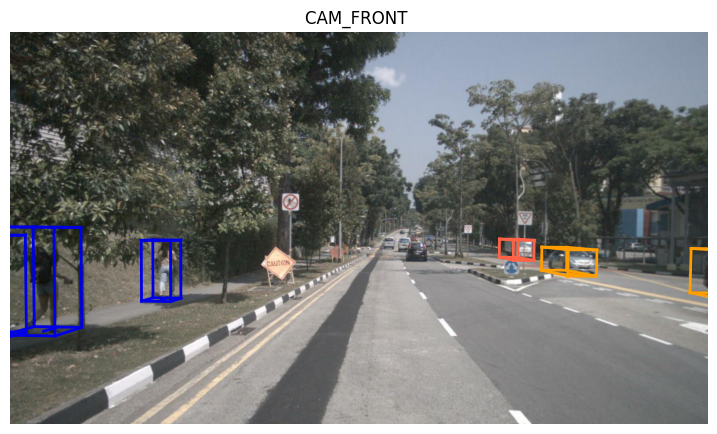

In [17]:
nusc.render_sample_data(cam_front_data['token'])

In [18]:
image_path = os.path.join(nusc.dataroot, cam_front_data['filename'])

In [19]:
im = Image.open(image_path)

## Run Prediction

In [20]:
results = model(image_path, conf=CONFIDENCE_THRESHOLD, iou=IOU_THRESHOLD)


image 1/1 /home/012392471@SJSUAD/master_project/nuscenes_tests/../data/nuscenes/samples/CAM_FRONT/n015-2018-10-02-10-50-40+0800__CAM_FRONT__1538448744412460.jpg: 384x640 2 persons, 2 cars, 48.1ms
Speed: 1.3ms preprocess, 48.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


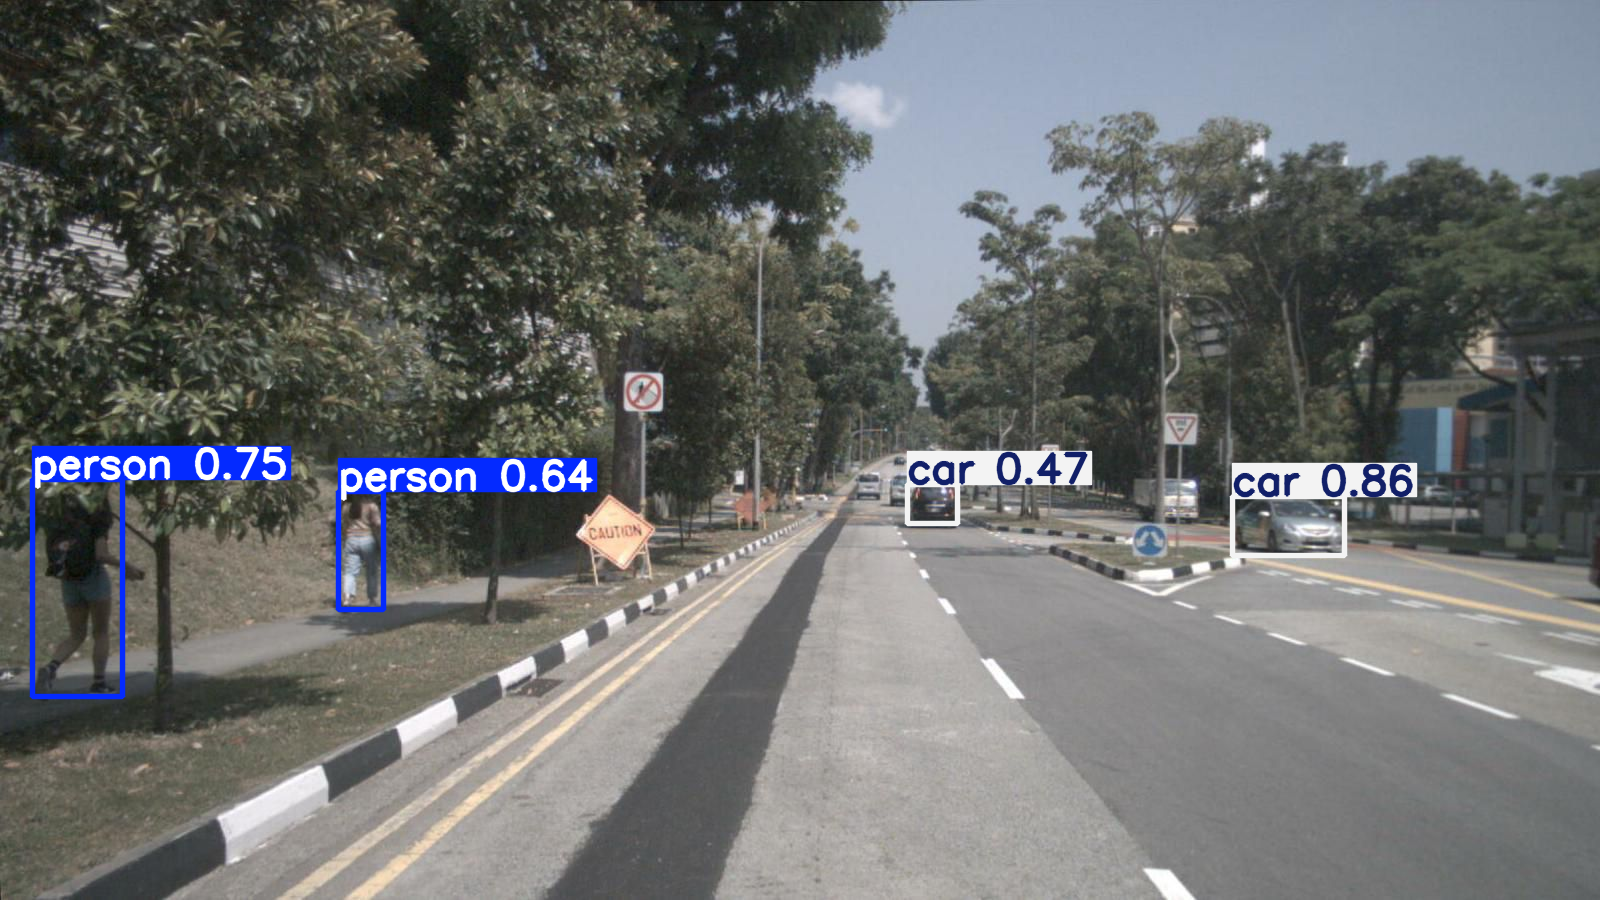

In [21]:
results[0].show()

## Manual Bounding Boxes

In [23]:
im = np.array(im)

In [56]:
for box in results[0].boxes:
    print(box.xyxy.tolist()[0])
    x1, y1, x2, y2 = map(int, box.xyxy.tolist()[0])
    class_id = int(box.cls)
    class_name = results[0].names[class_id]
    confidence = box.conf.item()
    
    # if confidence < .8:
        # continue
    
    # Draw rectangle and label on the frame
    cv2.rectangle(im, (x1, y1), (x2, y2), (0, 255, 0), 2)
    label = f"{class_name}: {confidence:.2f}"
    cv2.putText(im, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

[1232.8670654296875, 496.1757507324219, 1344.5882568359375, 555.139404296875]
[32.13340759277344, 479.7017517089844, 122.2371826171875, 696.3225708007812]
[338.5606994628906, 491.6065979003906, 383.8116455078125, 609.4304809570312]
[907.9826049804688, 484.20965576171875, 957.1348266601562, 523.3008422851562]


In [61]:
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [62]:
cv2.imwrite("result.jpg", im)

True

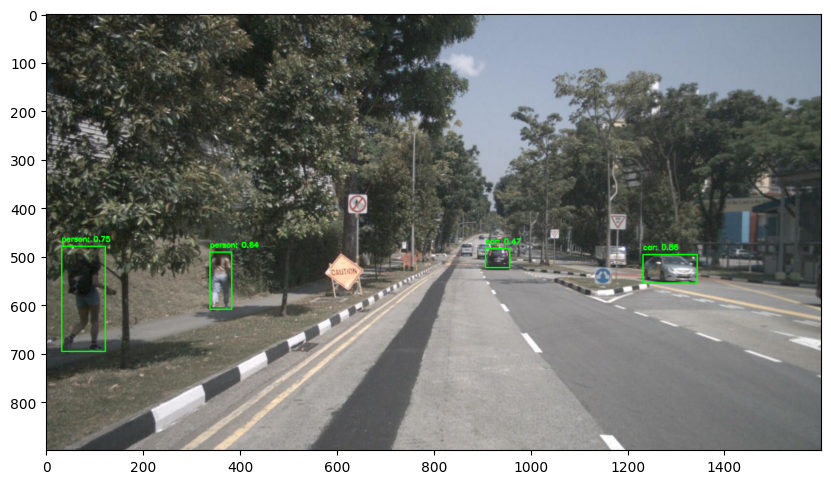

In [63]:
plt.figure(figsize=(10,15))
plt.imshow(im)

## Evaluate Performance

In [60]:
# for ann in my_sample['anns']:
#     x = nusc.get('sample_annotation', ann)
#     print(x)
#     print(x['category_name'])
#     print()